# __Building a Movie Recommender with the MovieLens Dataset__



__Group One Members__
* Esther Francis - Phase Four Group Leader
* Doreen Wanjiru
* Ian Korir
* Gregory Mikuro - Scrum Master

__Team Responsibilities:__ https://github.com/users/gregorymikuro/projects/4 

__Student pace:__ Hybrid

__Instructor name:__ Nikita Njoroge
 

## __1.0 Business Understanding__

Objectives

1. Analyze and determine movie ratings considering the number of raters and the overall distribution of ratings by calculating the Bayesian average to ensure that ratings are representative and not overly influenced by the number of raters.

2. Investigate relationships between user preferences and movie features through matrix factorization techniques, such as Singular Value Decomposition (SVD) to help in understanding how latent factors can capture the underlying patterns in user-movie interactions.

3.  Create and deploy a hybrid recommendation system that integrates collaborative filtering with content-based filtering that addresses the cold start problem and optimizes recommendation accuracy by combining the strengths of both methods.

## __2.0 Data Understanding__

## __3.0 Data Preparation__ 

### __3.1 Importing necessary Libraries__

In [1]:
# Import Libraries
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from surprise import Reader, Dataset, SVD
from wordcloud import WordCloud
from scipy import sparse 
from surprise import Reader, Dataset
from sklearn.metrics.pairwise import cosine_similarity
from fuzzywuzzy import process
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from sklearn.preprocessing import MultiLabelBinarizer
from surprise.model_selection import cross_validate
from sklearn.decomposition import TruncatedSVD
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
import pickle



### Loading the Datasets

In [2]:
class MovieLensDataExplorer:
    def __init__(self, ratings_path, movies_path, links_path=None, tags_path=None):
        self.ratings = pd.read_csv(ratings_path)
        self.movies = pd.read_csv(movies_path)
        self.links = pd.read_csv(links_path) if links_path else None
        self.tags = pd.read_csv(tags_path) if tags_path else None

    def show_info(self):
        print("## Ratings Data:")
        print(self.ratings.info())
        print("\n## Movies Data:")
        print(self.movies.info())
        if self.links is not None:
            print("\n## Links Data:")
            print(self.links.info())
        if self.tags is not None:
            print("\n## Tags Data:")
            print(self.tags.info())

    def overview(self):
        for df_name, df in zip(['ratings', 'movies', 'links', 'tags'], [self.ratings, self.movies, self.links, self.tags]):
            if df is None:
                continue
            print(f"\n## {df_name.capitalize()} Data Overview:")
            print(df.head().to_markdown(index=False, numalign="left", stralign="left"))  # Show first few rows
            print(f"\nShape: {df.shape}")

            # Unique Values and Missing Values
            unique_counts = df.apply(lambda x: len(set(x.dropna())))
            missing_counts = df.isnull().sum()
            missing_percent = (missing_counts / len(df)) * 100

            summary_df = pd.DataFrame({
                'Unique Values': unique_counts,
                'Missing Values': missing_counts,
                '% Missing': missing_percent
            })
            print(summary_df.to_markdown(numalign="left", stralign="left"))

    def visualize(self):
        # Rating Distribution
        plt.figure(figsize=(8, 5))
        sns.countplot(x='rating', data=self.ratings, hue='rating', dodge=False, palette="viridis")
        plt.legend([],[], frameon=False)
        plt.title("Distribution of Movie Ratings")
        plt.show()

        # Number of Ratings per User and Movie
        plt.figure(figsize=(14, 5))
        plt.subplot(1, 2, 1)
        sns.histplot(self.ratings.groupby('userId')['rating'].count(), bins=30, kde=True)
        plt.title("Number of Ratings per User")
        plt.subplot(1, 2, 2)
        sns.histplot(self.ratings.groupby('movieId')['rating'].count(), bins=30, kde=True)
        plt.title("Number of Ratings per Movie")
        plt.show()

        # Genre Distribution (if movies data is available)
        if self.movies is not None:
            all_genres = [genre for genres in self.movies['genres'].str.split('|') for genre in genres]
            genre_counts = pd.Series(all_genres).value_counts()
        
            plt.figure(figsize=(10, 6))
            
            # Create a custom color palette (optional, but enhances visual clarity)
            palette = sns.color_palette("husl", len(genre_counts))
            
            # Plot the barplot, assigning a specific color to each genre from the palette
            bars = plt.bar(genre_counts.index, genre_counts.values, color=palette)
        
            # Manually create legend handles and labels
            legend_elements = [plt.Rectangle((0, 0), 1, 1, color=palette[i], label=label) 
                               for i, label in enumerate(genre_counts.index)]
        
            plt.xticks(rotation=70)
            plt.xlabel("Genres")
            plt.title("Genre Distribution")
            
            # Place the legend
            plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
            
            plt.tight_layout()
            plt.show()




In [3]:
explorer = MovieLensDataExplorer('data/ratings.csv', 'data/movies.csv', 'data/links.csv', 'data/tags.csv')

In [4]:


# Basic Info

explorer.show_info() 


## Ratings Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
None

## Movies Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB
None

## Links Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movi

* The MovieLens dataset contains 100,836 ratings from 610 users on 9,742 movies, with additional movie metadata (titles, genres) and links to external databases.

* The dataset also includes 3,683 user-provided tags for movies, though this represents a small fraction of the total movie-rating interactions. 

In [5]:
# overview and summary of stats

explorer.overview()



## Ratings Data Overview:
| userId   | movieId   | rating   | timestamp   |
|:---------|:----------|:---------|:------------|
| 1        | 1         | 4        | 9.64983e+08 |
| 1        | 3         | 4        | 9.64981e+08 |
| 1        | 6         | 4        | 9.64982e+08 |
| 1        | 47        | 5        | 9.64984e+08 |
| 1        | 50        | 5        | 9.64983e+08 |

Shape: (100836, 4)
|           | Unique Values   | Missing Values   | % Missing   |
|:----------|:----------------|:-----------------|:------------|
| userId    | 610             | 0                | 0           |
| movieId   | 9724            | 0                | 0           |
| rating    | 10              | 0                | 0           |
| timestamp | 85043           | 0                | 0           |

## Movies Data Overview:
| movieId   | title                              | genres                                      |
|:----------|:-----------------------------------|:---------------------------------------

* Consistent Movie IDs: The movieId column appears consistently across the ratings, movies, and links datasets, facilitating seamless integration for analysis.
* Sparse Tags Data: The tags dataset is significantly smaller than the ratings dataset, indicating that not all users provide tags for the movies they rate. This suggests that tags might offer a more focused view of specific movie attributes.
* Missing tmdb IDs: There are 8 missing values in the tmdbId column of the links dataset (0.08%).

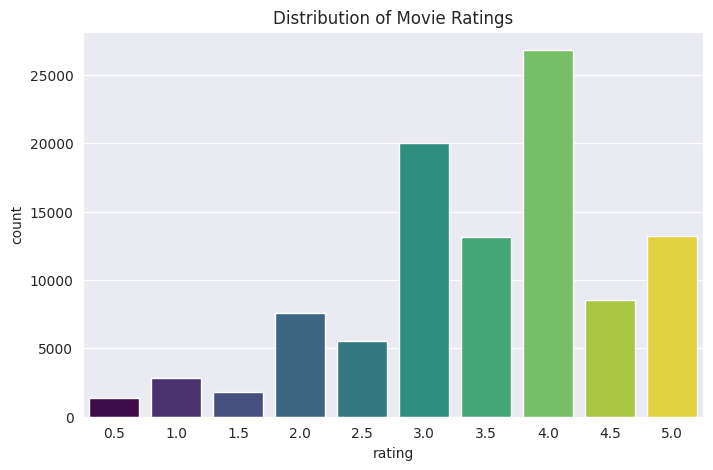

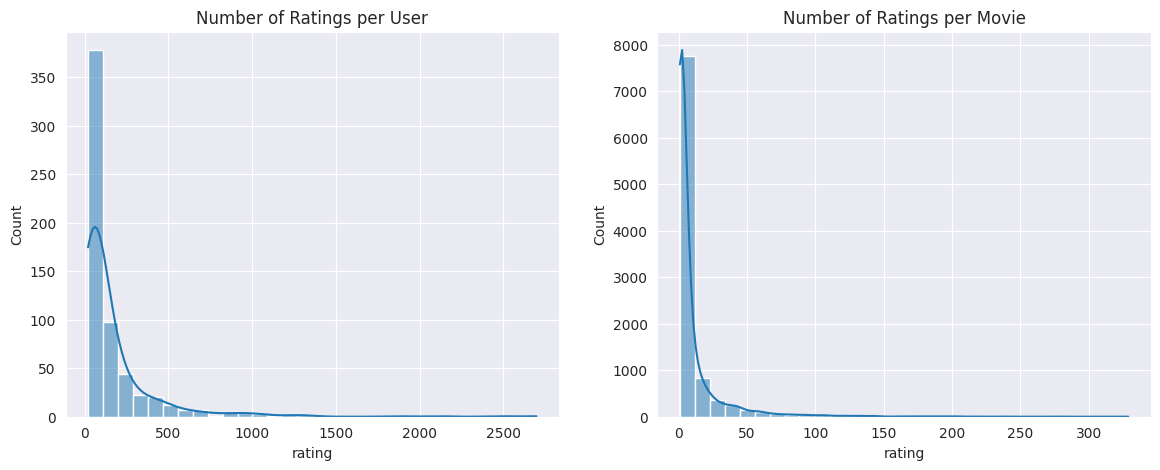

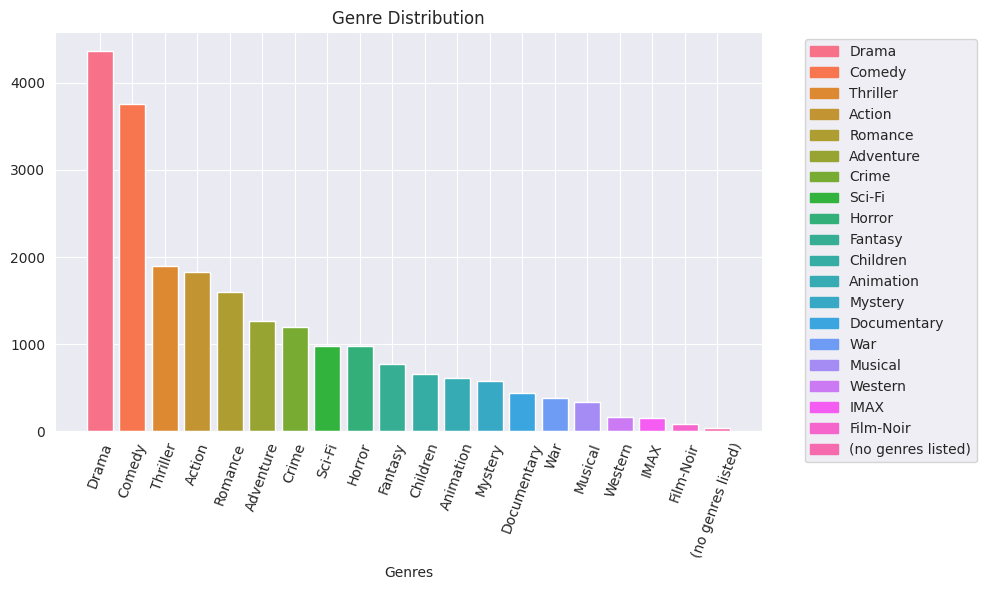

In [6]:
# Overall distributions

explorer.visualize()


* Rating Preferences: The most common ratings are 4 and 3, indicating a general tendency towards positive reviews, but also a significant portion of average ratings.
* Power Users and Popular Movies: A few users have rated a large number of movies (the long tail in the 'Number of Ratings per User' distribution), and a few movies have received a large number of ratings (the long tail in 'Number of Ratings per Movie' distribution). These outliers could significantly influence collaborative filtering recommendations.
* Genre Diversity: The dataset covers a wide range of genres, but some are more prevalent than others (e.g., Drama, Comedy, Thriller). This suggests that the recommender system might need to handle genre imbalances or incorporate content-based filtering to recommend movies from less popular genres.

## __4.0 Data Cleaning__ 

In this analysis, we'll prioritize the core user-item interactions captured in the `ratings` and `movies` datasets.  The `links` dataset, providing links to external databases (IMDb and TMDb), is not directly relevant to our collaborative filtering approach and will be excluded.  While the `tags` dataset offers potentially valuable insights into movie content, its inherent sparsity (only 3683 tags compared to 100,836 ratings) and potential user bias pose challenges for its inclusion in this initial analysis.

Our data cleaning strategy aims to refine the dataset for subsequent analysis and modeling:

1.  **Merge `ratings` and `movies`:** We'll merge the `ratings` and `movies` DataFrames on the `movieId` column. This consolidation is essential for associating user ratings with specific movie titles and genres, enabling us to examine user preferences in relation to movie attributes and facilitating various recommendation strategies.

2.  **Timestamp Removal:** The `timestamp` column, while potentially useful for temporal analysis, is not immediately relevant.  Therefore, we'll drop this column to reduce the dataset's dimensionality and computational burden.

3.  **Duplicate Elimination:** We'll rigorously identify and remove duplicate entries within the merged DataFrame, ensuring each user-movie rating pair is unique. This step is crucial to prevent biases in subsequent analyses and models arising from duplicate ratings.

4.  **Genre Transformation:** The `genres` column in the `movies` DataFrame contains multiple genres per movie separated by '|'. We'll split this column into a list of individual genres to enable genre-based analysis and filtering, as well as potential integration into content-based filtering strategies if desired later.

5. **Title-Year Separation:** We will also extract the release year from the movie title and store it as a separate column for further analysis.
 
6. **Bayesian Average Calculation:** We'll compute the Bayesian Average for each movie's rating.  This approach mitigates the inherent bias of simple average ratings, especially for movies with few ratings, by incorporating the global average rating and the average number of votes per movie. The Bayesian Average formula is:

```
Bayesian Average = ( (C * m) + (R * v) ) / (C + v)
```

where:

*   R = average rating for the movie
*   v = number of votes for the movie
*   m = average rating across all movies
*   C = average number of votes per movie across all movies

By comparing the Bayesian Average with simple average ratings, we'll assess the impact of this adjustment on the perceived popularity of movies, particularly those with limited ratings. We'll visually represent this comparison to discern how the Bayesian Average smooths out the rating distribution.


In [7]:
class MovieLensDataCleaner:
    def __init__(self, ratings_path, movies_path, min_reviews):
        self.ratings = pd.read_csv(ratings_path)
        self.movies = pd.read_csv(movies_path)
        self.min_reviews = min_reviews
        self.cleaned_df = None
        self.result_df = None

    def clean_and_merge(self):
        # Merge DataFrames
        df = pd.merge(self.ratings, self.movies, on='movieId')

        # Drop Timestamp
        df.drop('timestamp', axis=1, inplace=True)

        # Drop Duplicates
        df.drop_duplicates(inplace=True)

        # Genre Cleaning
        df['genres'] = df['genres'].str.split('|')

        # Extract Title and Year
        df['year'] = df['title'].str.extract(r'\((\d{4})\)', expand=False)
        df['year'] = pd.to_numeric(df['year'], errors='coerce')

        # Impute missing year values with median before dropping NaNs
        median_year = df['year'].median()
        df['year'] = df['year'].fillna(median_year).astype(int)

        df['title'] = df['title'].str.replace(r'\(\d{4}\)', '', regex=True).str.strip()

        # Drop NaN values for all columns (including year) after imputation
        self.cleaned_df = df.dropna()

        return self.cleaned_df

    def calculate_bayesian_average(self):
        if self.cleaned_df is None:
            raise ValueError("Data not cleaned. Call 'clean_and_merge' before calculating Bayesian average.")
        
        # Calculate mean rating and number of ratings for each movie
        movie_stats = self.cleaned_df.groupby('movieId').agg({'rating': ['mean', 'count']})
        movie_stats.columns = ['mean', 'count']
        
        # Calculate the global mean rating
        global_mean = self.cleaned_df['rating'].mean()
        
        # Calculate the Bayesian average
        def bayesian_avg(row):
            m = self.min_reviews
            v = row['count']
            r = row['mean']
            return (v / (v + m)) * r + (m / (v + m)) * global_mean
        
        movie_stats['bayesian_avg'] = movie_stats.apply(bayesian_avg, axis=1)
        
        # Join the Bayesian average with the cleaned dataframe
        self.result_df = self.cleaned_df.join(movie_stats['bayesian_avg'], on='movieId')
        self.result_df = self.result_df.rename(columns={"bayesian_avg": "avg_rating"})
        
        # Drop unnecessary columns
        self.result_df = self.result_df.drop(columns=['mean', 'count'], errors='ignore')
        
        return self.result_df

    def save_cleaned_data(self):
        if self.result_df is None:
            raise ValueError("Data not processed. Call 'calculate_bayesian_average' before saving cleaned data.")
    
        # Drop the 'rating' column
        result_df = self.result_df.drop(columns=['rating'], errors='ignore')
    
        # Save the cleaned data to CSV in the data folder, overwriting if exists
        output_path = os.path.join('data', 'cleaned-data.csv')
        os.makedirs(os.path.dirname(output_path), exist_ok=True)  # Create directory if it doesn't exist
        result_df.to_csv(output_path, index=False, mode='w')  # Use mode='w' to overwrite
        print(f"Cleaned data saved to: {output_path}")

In [8]:
cleaner = MovieLensDataCleaner('data/ratings.csv', 'data/movies.csv', min_reviews=50)

In [9]:
cleaned_df = cleaner.clean_and_merge()


In [10]:

df_with_bayesian_avg = cleaner.calculate_bayesian_average()
df_with_bayesian_avg.info()
df_with_bayesian_avg


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   userId      100836 non-null  int64  
 1   movieId     100836 non-null  int64  
 2   rating      100836 non-null  float64
 3   title       100836 non-null  object 
 4   genres      100836 non-null  object 
 5   year        100836 non-null  int64  
 6   avg_rating  100836 non-null  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 5.4+ MB


,userId,movieId,rating,title,genres,year,avg_rating
0,1,1,4.0,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,3.841803
1,1,3,4.0,Grumpier Old Men,"[Comedy, Romance]",1995,3.378214
2,1,6,4.0,Heat,"[Action, Crime, Thriller]",1995,3.799854
3,1,47,5.0,Seven (a.k.a. Se7en),"[Mystery, Thriller]",1995,3.881731
4,1,50,5.0,"Usual Suspects, The","[Crime, Mystery, Thriller]",1995,4.092826
...,...,...,...,...,...,...,...
100831,610,166534,4.0,Split,"[Drama, Horror, Thriller]",2017,3.483533
100832,610,168248,5.0,John Wick: Chapter Two,"[Action, Crime, Thriller]",2017,3.580313
100833,610,168250,5.0,Get Out,[Horror],2017,3.531967
100834,610,168252,5.0,Logan,"[Action, Sci-Fi]",2017,3.761038


The Bayesian Average rating significantly adjusts the perceived ranking of movies with few ratings, potentially elevating lesser-known films in the recommendations. Movies with many ratings experience minimal adjustments, as their average rating is already a reliable indicator of popularity. No duplicate ratings were found in the dataset, ensuring the integrity of subsequent analyses.

In [11]:
cleaner.save_cleaned_data()

Cleaned data saved to: data/cleaned-data.csv


## __5.0 Exploratory Data Analysis__

### __5.1 Univariate Analysis__

The `MovieLensUnivariateEDA` class below performs exploratory data analysis on a MovieLens dataset. It analyzes the distribution of movie ratings, identifies the most and least common genres, assesses the relationship between movie popularity and average ratings, examines the distribution of movies over time, and identifies the top and bottom rated movies and users.

In [12]:
class MovieLensUnivariateEDA:
    def __init__(self, data_path='data/cleaned-data.csv'):
        self.df = pd.read_csv(data_path)

    def analyze_ratings(self):
        print("### Rating Distribution Analysis:")

        # Histogram of avg_rating
        plt.figure(figsize=(8, 6))
        sns.histplot(self.df['avg_rating'], bins=10, kde=True, color='skyblue')
        plt.title('Distribution of Average Movie Ratings')
        plt.xlabel('Average Rating')
        plt.ylabel('Frequency')
        plt.show()

    def analyze_genres(self):
        print("\n### Genre Analysis:")

        # Flatten and Count Genres
        all_genres = [genre for genres in self.df['genres'].apply(eval) for genre in genres]
        genre_counts = pd.Series(all_genres).value_counts()

        # Bar plot of Top 10 and Least 10 Genres
        fig, axes = plt.subplots(1, 2, figsize=(20, 6))
        sns.barplot(x=genre_counts[:10].index, y=genre_counts[:10].values, ax=axes[0], hue=genre_counts[:10].index, dodge=False, palette='viridis')
        axes[0].legend([],[], frameon=False)  # Remove legend
        axes[0].set_title('Top 10 Movie Genres by Frequency')
        axes[0].set_xlabel('Genre')
        axes[0].set_ylabel('Count')
        axes[0].tick_params(axis='x', rotation=45)
        sns.barplot(x=genre_counts[-10:].index, y=genre_counts[-10:].values, ax=axes[1], hue=genre_counts[-10:].index, dodge=False, palette='viridis')
        axes[1].legend([],[], frameon=False)  # Remove legend
        axes[1].set_title('Least 10 Movie Genres by Frequency')
        axes[1].set_xlabel('Genre')
        axes[1].set_ylabel('Count')
        axes[1].tick_params(axis='x', rotation=45)
        plt.show()

        # Word cloud of Genres (Larger and more readable)
        wordcloud = WordCloud(width=1200, height=600, background_color='white', min_font_size=10).generate_from_frequencies(genre_counts)
        plt.figure(figsize=(15, 8))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title('Word Cloud of Movie Genres')
        plt.show()

    def analyze_popularity(self):
        print("\n### Movie Popularity Analysis:")

        # Calculate rating counts per movie
        movie_rating_counts = self.df['movieId'].value_counts()

        # Simple scatterplot (without genre hue)
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=movie_rating_counts, y=self.df.groupby('movieId')['avg_rating'].mean(), color='skyblue', alpha=0.5)
        plt.title('Average Rating vs. Number of Ratings per Movie')
        plt.xlabel('Number of Ratings')
        plt.ylabel('Average Rating')
        plt.show()

    def analyze_years(self):
        print("\n### Year Analysis:")

        # Calculate 4-year ranges
        min_year = int(self.df['year'].min())
        max_year = int(self.df['year'].max())
        bins = range(min_year, max_year + 5, 4)  # Create bins in 4-year intervals

        # Create year_range column
        self.df['year_range'] = pd.cut(self.df['year'], bins=bins, labels=False) * 4 + min_year

        # Bar chart of Number of Movies per Year Range
        year_range_counts = self.df['year_range'].value_counts().sort_index()
        plt.figure(figsize=(12, 6))
        sns.barplot(x=year_range_counts.index, y=year_range_counts.values, color='skyblue')
        plt.title('Number of Movies per 4-Year Range')
        plt.xlabel('Year Range')
        plt.ylabel('Number of Movies')
        plt.xticks(rotation=45)
        plt.show()

    def analyze_top_bottom(self, top_n=5):
        print("\n### Top and Bottom Rated Movies & Users:")
        
        # Top and Bottom Movies by Average Rating
        top_movies = self.df.groupby('title')['avg_rating'].mean().nlargest(top_n)
        bottom_movies = self.df.groupby('title')['avg_rating'].mean().nsmallest(top_n)
    
        print("\nTop Rated Movies:")
        print(top_movies.to_markdown(numalign='left', stralign='left'))
        print("\nBottom Rated Movies:")
        print(bottom_movies.to_markdown(numalign='left', stralign='left'))
    
        # Top and Bottom Users by Average Rating
        top_users = self.df.groupby('userId')['avg_rating'].mean().nlargest(top_n)
        bottom_users = self.df.groupby('userId')['avg_rating'].mean().nsmallest(top_n)
    
        print("\nTop Raters (By Average Rating):")
        print(top_users.to_markdown(numalign='left', stralign='left'))
        print("\nBottom Raters (By Average Rating):")
        print(bottom_users.to_markdown(numalign='left', stralign='left'))
    
        # Top and Bottom Users by Number of Ratings (Bar Plots)
        user_rating_counts = self.df.groupby('userId')['avg_rating'].count()
        top_raters_by_count = user_rating_counts.nlargest(top_n)
        bottom_raters_by_count = user_rating_counts.nsmallest(top_n)
    
        print("\nTop Raters (By Number of Ratings):")
        print(top_raters_by_count.to_markdown(numalign='left', stralign='left'))
        print("\nBottom Raters (By Number of Ratings):")
        print(bottom_raters_by_count.to_markdown(numalign='left', stralign='left'))
    
        

In [13]:
# df_check = pd.read_csv('data/cleaned-data.csv')
# df_check.info()

In [14]:
eda = MovieLensUnivariateEDA()  


### Rating Distribution Analysis:


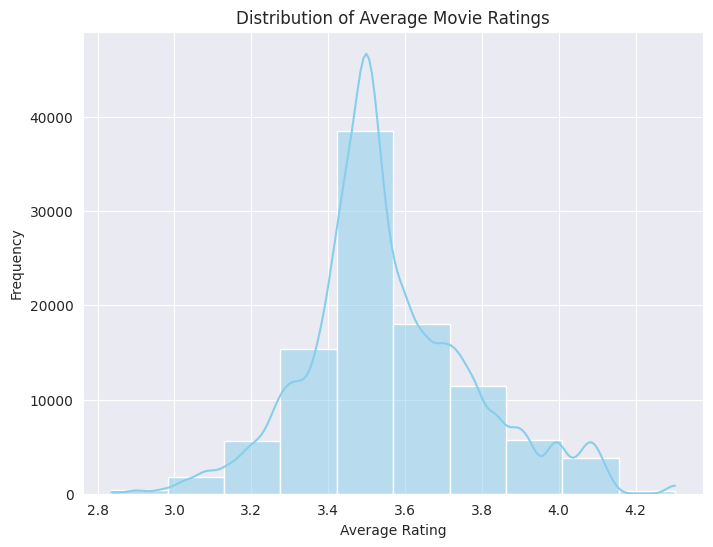

In [15]:
eda.analyze_ratings()


### Genre Analysis:


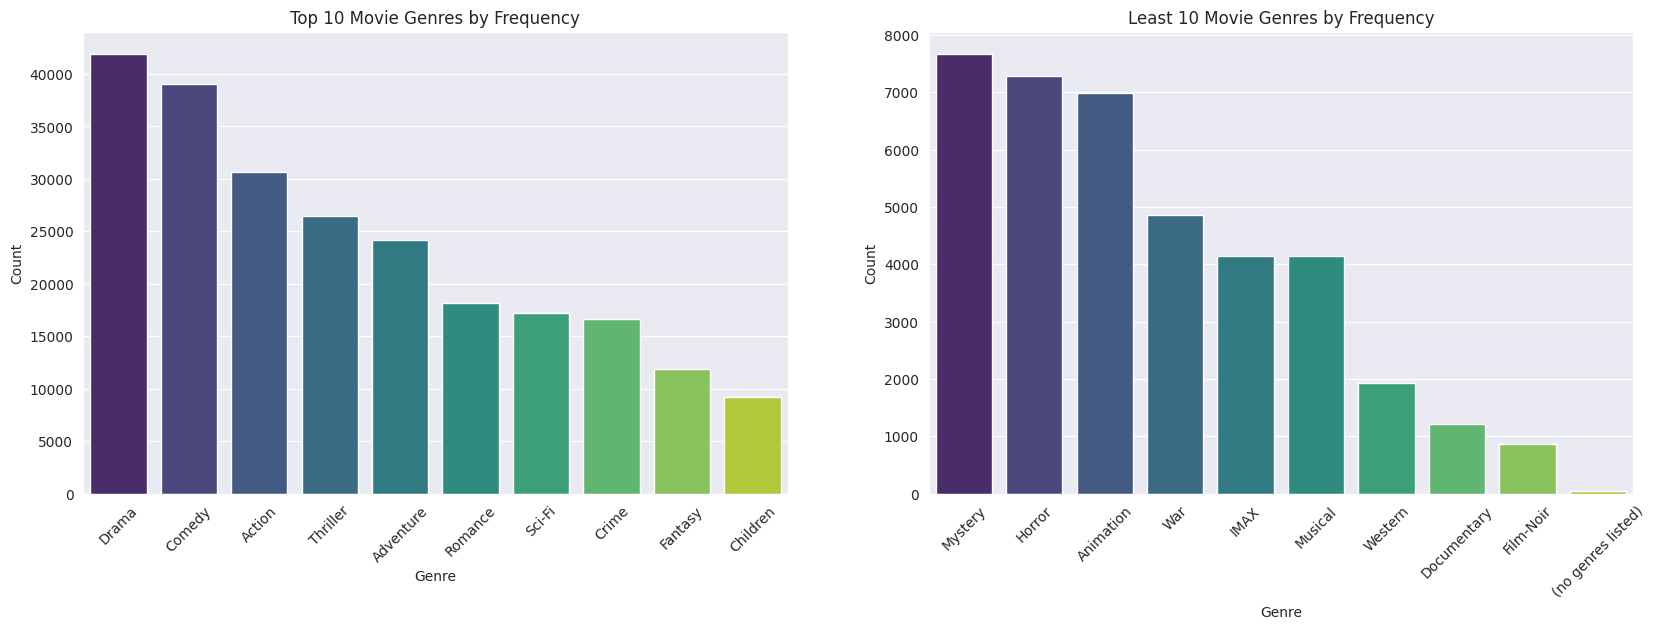

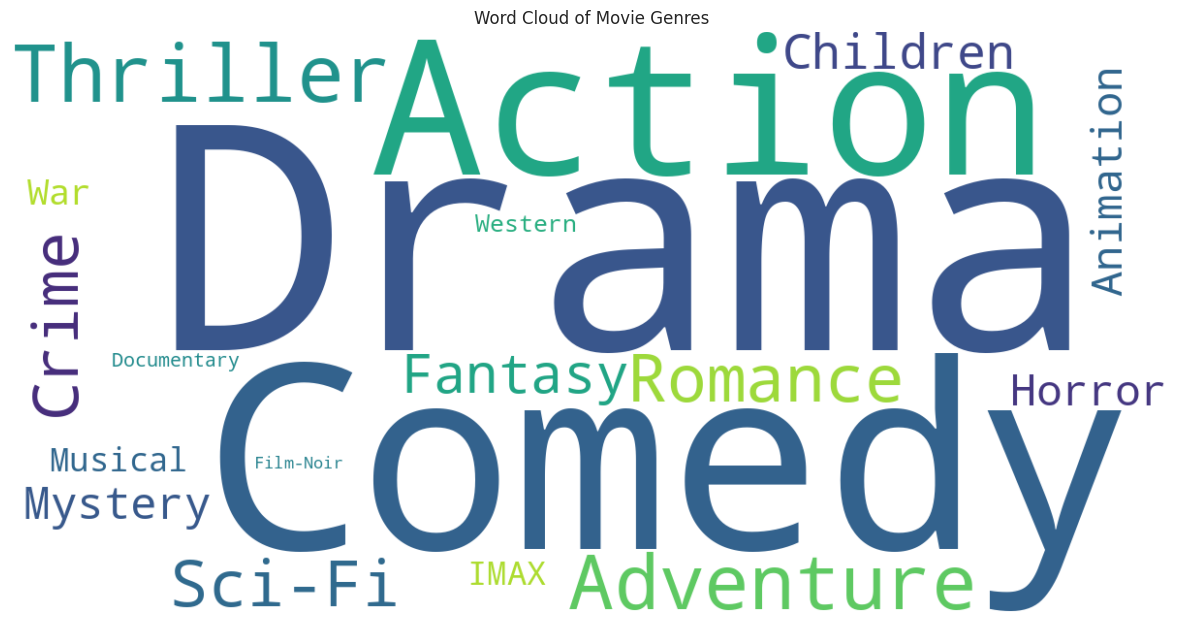

In [16]:
eda.analyze_genres()


### Movie Popularity Analysis:


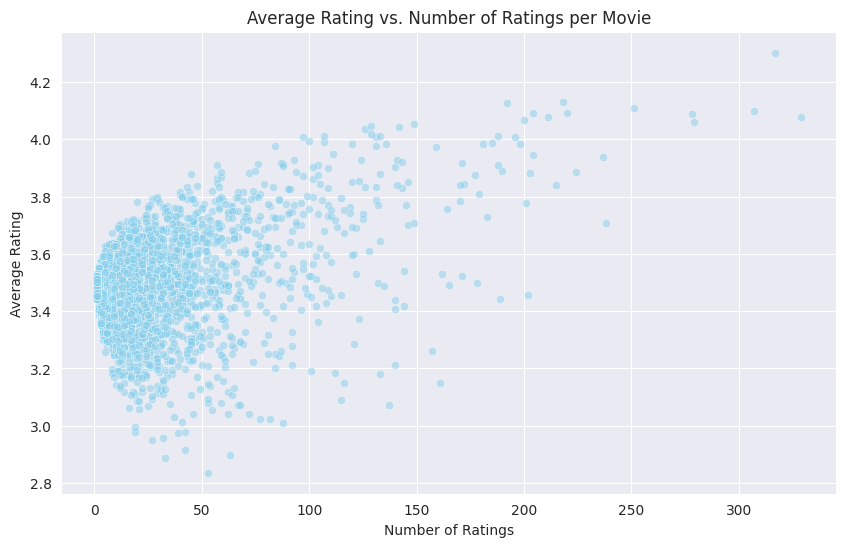

In [17]:
eda.analyze_popularity()


### Year Analysis:


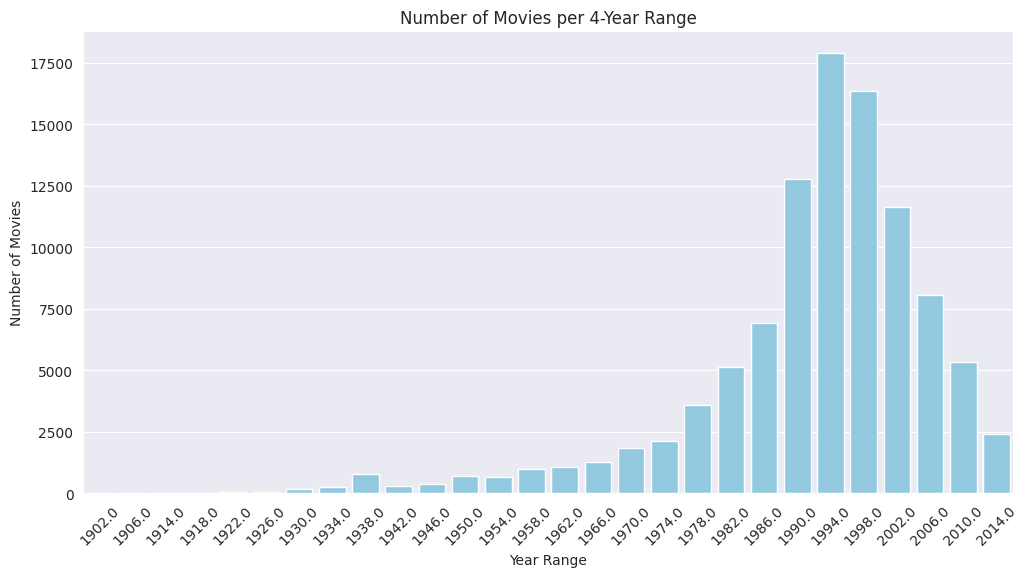

In [18]:
eda.analyze_years()

In [19]:
eda.analyze_top_bottom()


### Top and Bottom Rated Movies & Users:

Top Rated Movies:
| title                              | avg_rating   |
|:-----------------------------------|:-------------|
| Shawshank Redemption, The          | 4.30266      |
| Fight Club                         | 4.12902      |
| Godfather, The                     | 4.12635      |
| Star Wars: Episode IV - A New Hope | 4.10989      |
| Pulp Fiction                       | 4.09966      |

Bottom Rated Movies:
| title                           | avg_rating   |
|:--------------------------------|:-------------|
| Wild Wild West                  | 2.83571      |
| Coneheads                       | 2.89892      |
| Batman & Robin                  | 2.91389      |
| Anaconda                        | 2.94906      |
| I Know What You Did Last Summer | 2.95827      |

Top Raters (By Average Rating):
| userId   | avg_rating   |
|:---------|:-------------|
| 549      | 3.94902      |
| 189      | 3.94202      |
| 251      | 3.93876      |
| 231    

### __5.2 Bivariate Analysis__

The MovieLensBivariateEDA class below performs bivariate analysis on the MovieLens dataset. It investigates the relationship between the average movie rating and two other variables: year of release and genre. This helps us understand how ratings vary depending on when a movie was released and what genre it belongs to. 


### Year vs. Average Rating Analysis:


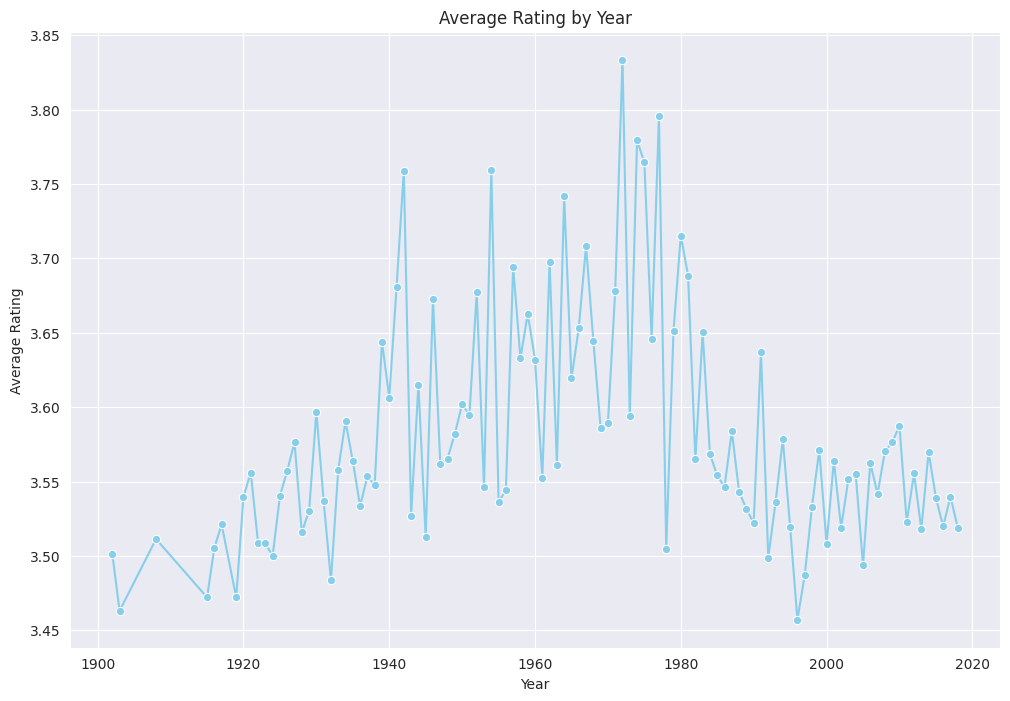


### Genres vs. Average Rating Analysis:


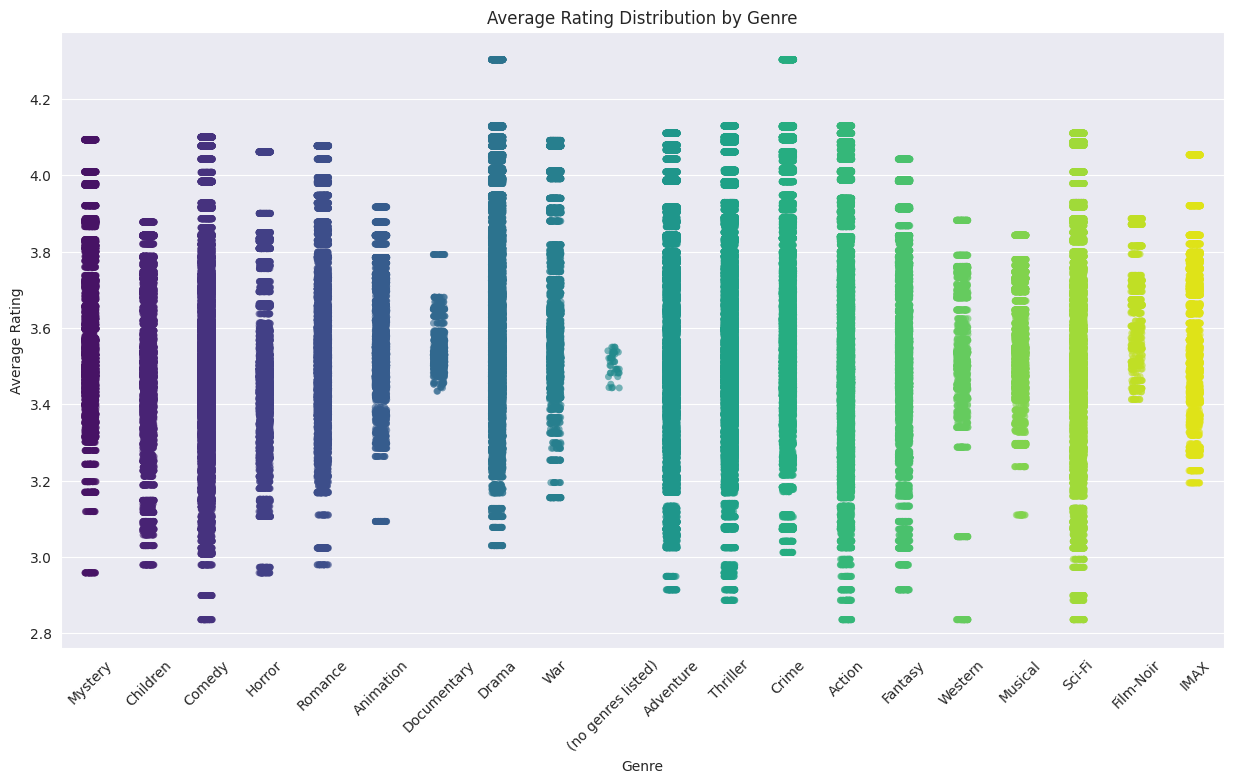

In [20]:
class MovieLensBivariateEDA:
    def __init__(self, data_path='data/cleaned-data.csv'):
        self.df = pd.read_csv(data_path)
        self.df['genres'] = self.df['genres'].apply(eval)  # Ensure genres are lists
        self._prepare_genre_columns()

    def _prepare_genre_columns(self):
        # Get a set of all unique genres
        unique_genres = set(g for genres in self.df['genres'] for g in genres)
        
        # Create a column for each genre
        for genre in unique_genres:
            self.df[genre] = self.df['genres'].apply(lambda x: 1 if genre in x else 0)

    def analyze_year_vs_avg_rating(self):
        print("\n### Year vs. Average Rating Analysis:")

        # Calculate average rating for each year
        year_avg_ratings = self.df.groupby('year')['avg_rating'].mean()

        # Plotting
        plt.figure(figsize=(12, 8))
        sns.lineplot(x=year_avg_ratings.index, y=year_avg_ratings.values, marker='o', color='skyblue')
        plt.title('Average Rating by Year')
        plt.xlabel('Year')
        plt.ylabel('Average Rating')
        plt.show()

    def analyze_genres_vs_avg_rating(self):
        print("\n### Genres vs. Average Rating Analysis:")

        # Create a long-form DataFrame for Seaborn
        genre_ratings = []
        for genre in self.df.columns:
            if genre not in ['userId', 'movieId', 'title', 'genres', 'year', 'avg_rating']:
                genre_data = self.df[self.df[genre] == 1]
                for rating in genre_data['avg_rating']:
                    genre_ratings.append((genre, rating))
        
        genre_ratings_df = pd.DataFrame(genre_ratings, columns=['Genre', 'Average Rating'])

        # Plotting
        plt.figure(figsize=(15, 8))
        sns.stripplot(x='Genre', y='Average Rating', data=genre_ratings_df, jitter=True, hue='Genre', palette='viridis', alpha=0.6, legend=False)
        plt.title('Average Rating Distribution by Genre')
        plt.xlabel('Genre')
        plt.ylabel('Average Rating')
        plt.xticks(rotation=45)
        plt.show()

# Example usage
eda = MovieLensBivariateEDA('data/cleaned-data.csv')
eda.analyze_year_vs_avg_rating()
eda.analyze_genres_vs_avg_rating()


analyze_year_vs_avg_rating() method calculates and visualizes the average rating of movies for each year using a line plot. It reveals trends in how movie ratings have evolved over time while analyze_genres_vs_avg_rating() method creates a new DataFrame with individual rows for each movie-genre combination along with their average ratings. It then uses a strip plot to visualize the distribution of average ratings across different genres, helping to identify if certain genres tend to receive higher or lower ratings on average.

### __5.3 Multivariate Analysis__ 

The `MultivariateAnalysis` class begins by initializing with a file path to the CSV data and the number of latent features for dimensionality reduction, which is set via `n_components`. It reads the data from the specified file using Pandas and prepares it for analysis. The `_prepare_data` method maps each movie ID to its title and index, then formats the data for the Surprise library, which is used to train the SVD model. The SVD model, initialized with the specified number of latent features, is trained on the prepared dataset. For similarity calculations, the `find_similar_movies` method computes the cosine similarity between the target movie vector and all other movie vectors. It then retrieves the top `k` most similar movies, excluding the target movie itself. The `plot_similarity_heatmap` method visualizes the similarity between the target movie and its top `k` similar movies by creating a heatmap, with movie titles as labels and similarity scores as annotations. Both methods include error handling to ensure the provided movie ID exists in the dataset. The cosine similarity is computed using the equation:

\[
\text{similarities} = \text{cosine\_similarity(movie\_vector, all\_movie\_vectors)}
\]

When generating the heatmap, the similarity matrix is computed with:

\[
\text{similarity\_matrix} = \text{cosine\_similarity(selected\_vectors)}
\]

In the `__main__` section, the class is instantiated with the data path and number of components, and methods are executed to find similar movies and plot the heatmap.

Movies similar to Sabrina:
American Pie
Quadrophenia
Watch, The
Valerian and the City of a Thousand Planets
Vera Drake


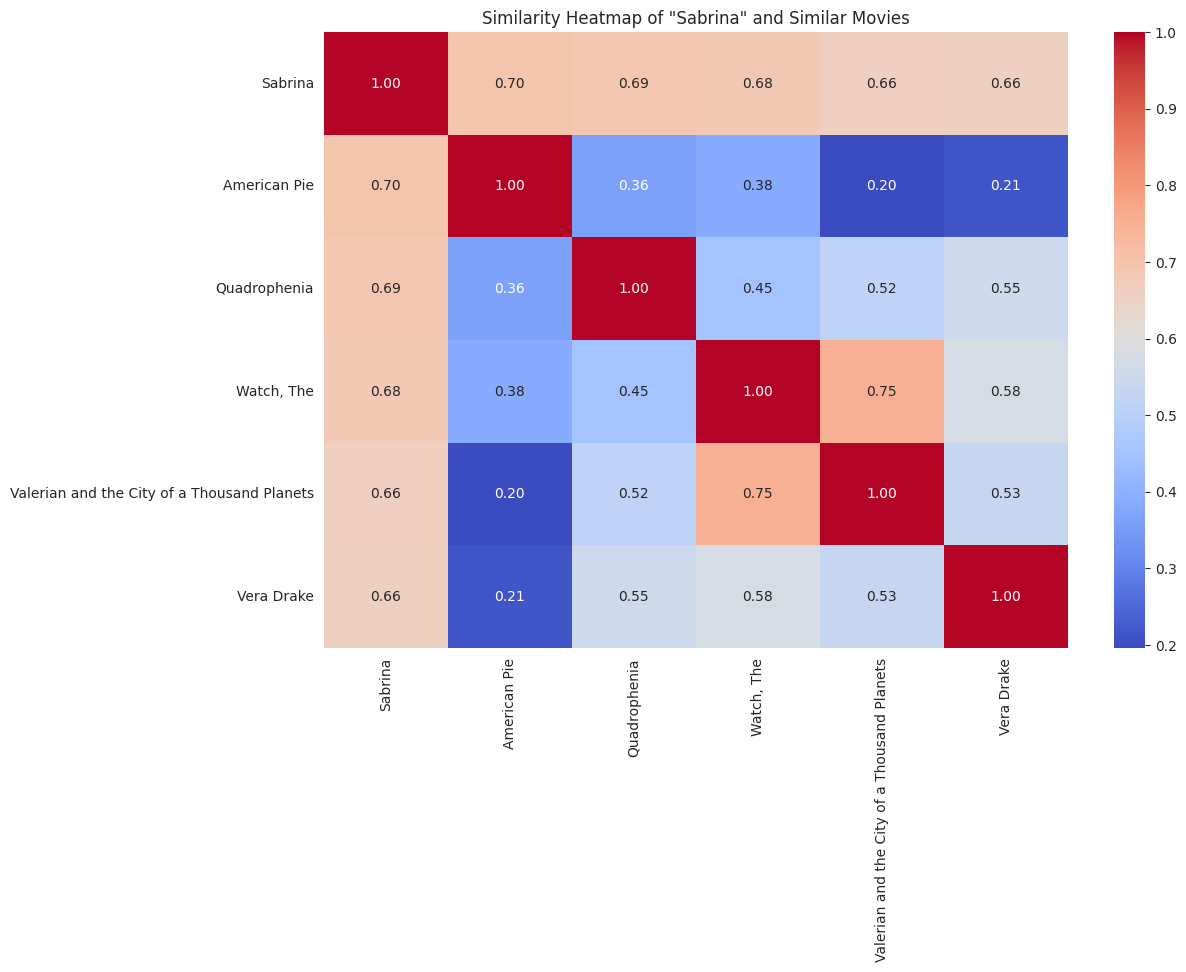

In [21]:
class MultivariateAnalysis:
    def __init__(self, data_path, n_components=20):
        """
        Initializes the MultivariateAnalysis class.

        Parameters:
        - data_path: Path to the CSV file containing the data.
        - n_components: Number of latent features for dimensionality reduction.
        """
        self.data = pd.read_csv(data_path)
        self.n_components = n_components
        self.model = None
        self.trainset = None
        self.movie_titles = {}
        self.movie_mapper = {}
        self.movie_inv_mapper = {}
        self._prepare_data()

    def _prepare_data(self):
        """
        Prepares the data for SVD model.
        """
        # Create a mapping of movieId to title and index
        movie_ids = self.data['movieId'].unique()
        self.movie_titles = self.data.drop_duplicates('movieId')[['movieId', 'title']].set_index('movieId')['title'].to_dict()
        self.movie_mapper = {movie_id: i for i, movie_id in enumerate(movie_ids)}
        self.movie_inv_mapper = {i: movie_id for i, movie_id in enumerate(movie_ids)}

        # Prepare data for surprise
        reader = Reader(rating_scale=(0.5, 5.0))
        data = Dataset.load_from_df(self.data[['userId', 'movieId', 'avg_rating']], reader)
        trainset = data.build_full_trainset()

        # Initialize and train the SVD model
        self.model = SVD(n_factors=self.n_components)
        self.model.fit(trainset)
        self.trainset = trainset

    def find_similar_movies(self, movie_id, top_k=5):
        """
        Finds similar movies to a given movie.

        Parameters:
        - movie_id: The ID of the movie to find similar movies for.
        - top_k: The number of similar movies to return.

        Returns:
        - A list of movie titles that are similar to the given movie.
        """
        if movie_id not in self.movie_mapper:
            raise ValueError("Movie ID not found in the dataset.")
        
        movie_index = self.movie_mapper[movie_id]
        movie_vector = np.array(self.model.qi[movie_index]).reshape(1, -1)
        all_movie_vectors = np.array(self.model.qi)
        similarities = cosine_similarity(movie_vector, all_movie_vectors)
        similar_indices = similarities.argsort()[0][-top_k-1:-1][::-1]  # Exclude the movie itself and sort

        similar_movies = [self.movie_titles[self.movie_inv_mapper[idx]] for idx in similar_indices]
        return similar_movies


    def plot_similarity_heatmap(self, movie_id, top_k=5):
        """
        Plots a heatmap of similarities between a movie and its similar movies.

        Parameters:
        - movie_id: The ID of the movie to find similar movies for.
        - top_k: The number of similar movies to return in the heatmap.
        """
        if movie_id not in self.movie_mapper:
            raise ValueError("Movie ID not found in the dataset.")

        movie_index = self.movie_mapper[movie_id]
        movie_vector = np.array(self.model.qi[movie_index]).reshape(1, -1)
        all_movie_vectors = np.array(self.model.qi)
        similarities = cosine_similarity(movie_vector, all_movie_vectors)
        similar_indices = similarities.argsort()[0][-top_k-1:-1][::-1]  # Exclude the movie itself and sort

        selected_indices = [movie_index] + similar_indices.tolist()
        selected_vectors = np.array([self.model.qi[idx] for idx in selected_indices])
        selected_titles = [self.movie_titles[self.movie_inv_mapper[idx]] for idx in selected_indices]

        similarity_matrix = cosine_similarity(selected_vectors)

        plt.figure(figsize=(12, 8))
        sns.heatmap(similarity_matrix, xticklabels=selected_titles, yticklabels=selected_titles, annot=True, fmt='.2f', cmap='coolwarm')
        plt.title(f'Similarity Heatmap of "{self.movie_titles[movie_id]}" and Similar Movies')
        plt.show()

if __name__ == "__main__":
    data_path = 'data/cleaned-data.csv'
    analysis = MultivariateAnalysis(data_path, n_components=20)
    
    movie_id = 7  # Example movieId
    similar_movies = analysis.find_similar_movies(movie_id)
    
    print(f"Movies similar to {analysis.movie_titles[movie_id]}:")
    for movie in similar_movies:
        print(movie)


    # Plot the similarity heatmap for the movie and its similar movies
    analysis.plot_similarity_heatmap(movie_id)


## __6.0 Modeling and Evaluation__

### __6.1 Data Pre-Processing__

The `DataPreprocessing` class initializes by loading data from a specified file path using Pandas. The `preprocess` method converts genre strings into lists, creates a user-item matrix, and generates a genre matrix. It first maps user and movie IDs to indices and vice versa, then builds a sparse user-item matrix using these indices and ratings. Additionally, it creates a binary genre matrix using `MultiLabelBinarizer`. Finally, the class is instantiated, and preprocessing is executed to obtain matrices and mappings, with movie titles indexed by movie ID.

In [22]:
class DataPreprocessing:
    def __init__(self, filepath):
        self.filepath = filepath
        self.data = pd.read_csv(filepath)
        
    def preprocess(self):
        # Convert genres from string representation to list
        self.data['genres'] = self.data['genres'].apply(eval)
        
        # Create user-item matrix
        self.X, self.user_mapper, self.movie_mapper, self.user_inv_mapper, self.movie_inv_mapper = self.create_user_item_matrix()
        
        # Create genre matrix
        self.genre_matrix = self.create_genre_matrix()
        
        return self.X, self.genre_matrix, self.user_mapper, self.movie_mapper, self.user_inv_mapper, self.movie_inv_mapper
    
    def create_user_item_matrix(self):
        M = self.data['userId'].nunique()
        N = self.data['movieId'].nunique()

        user_mapper = dict(zip(np.unique(self.data["userId"]), list(range(M))))
        movie_mapper = dict(zip(np.unique(self.data["movieId"]), list(range(N))))
        
        user_inv_mapper = dict(zip(list(range(M)), np.unique(self.data["userId"])))
        movie_inv_mapper = dict(zip(list(range(N)), np.unique(self.data["movieId"])))
        
        user_index = [user_mapper[i] for i in self.data['userId']]
        item_index = [movie_mapper[i] for i in self.data['movieId']]

        X = csr_matrix((self.data["avg_rating"], (user_index, item_index)), shape=(M, N))
        
        return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper
    
    def create_genre_matrix(self):
        mlb = MultiLabelBinarizer()
        genre_matrix = mlb.fit_transform(self.data['genres'])
        return genre_matrix
    
# Load and preprocess data
data_preprocessing = DataPreprocessing('data/cleaned-data.csv')
X, genre_matrix, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = data_preprocessing.preprocess()
movie_titles = data_preprocessing.data.set_index('movieId')['title'].to_dict()

### 6.1 __Modeling__

#### 6.1.1 Collaborative Filtering - Baseline Model

The `CollaborativeFiltering` class is designed to recommend movies similar to a given movie based on collaborative filtering techniques. Upon initialization, it stores the user-item matrix \( \mathbf{X} \), movie titles, and various mappings for users and movies. The `find_similar_movies` method identifies similar movies using the specified distance metric, either 'cosine' or 'euclidean'. It transposes the user-item matrix \( \mathbf{X} \) and checks if the movie ID exists in the dataset. If valid, it retrieves the movie vector and applies the `NearestNeighbors` algorithm to find the closest neighbors. The cosine similarity or Euclidean distance is computed as:

\[
d_{ij} = \sqrt{\sum_{k=1}^{n} (x_{ik} - x_{jk})^2}
\]

where \( x_{ik} \) and \( x_{jk} \) are the feature values for movies \( i \) and \( j \), respectively. It then excludes the movie itself from the results and maps the indices back to movie titles. The `cf_model` instance is created to find and print the top 5 similar movies for a specified movie ID.

In [23]:
class CollaborativeFiltering:
    def __init__(self, X, movie_titles, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper):
        self.X = X
        self.movie_titles = movie_titles
        self.user_mapper = user_mapper
        self.movie_mapper = movie_mapper
        self.user_inv_mapper = user_inv_mapper
        self.movie_inv_mapper = movie_inv_mapper
    
    def find_similar_movies(self, movie_id, k=5, metric='cosine'):
        """
        Finds similar movies to a given movie using collaborative filtering.

        Parameters:
        - movie_id: The ID of the movie to find similar movies for.
        - k: The number of similar movies to return.
        - metric: The distance metric to use ('cosine' or 'euclidean').

        Returns:
        - A list of movie titles that are similar to the given movie.
        """
        X = self.X.T

        if movie_id not in self.movie_mapper:
            raise ValueError("Movie ID not found in the dataset.")
        
        movie_ind = self.movie_mapper[movie_id]
        movie_vec = X[movie_ind].reshape(1, -1)
        
        # Initialize NearestNeighbors
        kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
        kNN.fit(X)
        
        # Find neighbors
        distances, indices = kNN.kneighbors(movie_vec, return_distance=True)
        
        # Exclude the movie itself
        similar_indices = indices[0][1:]
        
        # Retrieve movie IDs and titles
        similar_movie_ids = [self.movie_inv_mapper[idx] for idx in similar_indices]
        similar_movie_titles = [self.movie_titles[movie_id] for movie_id in similar_movie_ids]
        
        return similar_movie_titles
    
# Collaborative filtering model
cf_model = CollaborativeFiltering(X, movie_titles, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper)
similar_movies_cf = cf_model.find_similar_movies(movie_id=7, k=5)

print(f"Collaborative Filtering Recommendations for Movie ID 7:")
for title in similar_movies_cf:
    print(title)

Collaborative Filtering Recommendations for Movie ID 7:
Truth About Cats & Dogs, The
Father of the Bride Part II
Birdcage, The
Mr. Holland's Opus
Sense and Sensibility


The collaborative filtering approach has generated a list of tailored movie recommendations for Movie ID 7, featuring titles such as *The Birdcage* and *Sense and Sensibility*. This method effectively leverages user behavior and preferences to suggest relevant films. However, it’s important to acknowledge the potential for the cold start problem, which might impact the accuracy of recommendations for newly introduced or less frequently rated movies. Despite this, the current results reflect the system’s capacity to provide insightful and varied movie choices based on existing user interactions. There is a need to focus on addressing these cold start issues to further refine the recommendation accuracy.

### 6.1.2 Hybrid Approach 

The `HybridRecommender` class integrates content-based and collaborative filtering approaches to provide movie recommendations. It initializes with a user-item matrix \( \mathbf{X} \), a genre matrix, and various mappings for users and movies, along with thresholds for user and movie ratings. The `movie_finder` method uses fuzzy matching to find the closest movie title to a given input. The `get_content_based_recommendations` method computes similarity scores between the target movie's genre vector and all other genre vectors using cosine similarity:

\[
\text{sim\_scores} = \text{cosine\_similarity}(\mathbf{g}_{\text{target}}, \mathbf{G})
\]

where \( \mathbf{g}_{\text{target}} \) is the genre vector of the target movie, and \( \mathbf{G} \) is the matrix of all genre vectors. The `get_collaborative_recommendations` method identifies similar movies using collaborative filtering based on nearest neighbors and computes distances using either 'cosine' or 'euclidean' metrics. The `hybrid_recommendations` method decides whether to use content-based or collaborative filtering based on the user's rating history or the movie's rating history. It applies filtering based on thresholds for user and movie ratings to choose the most appropriate recommendation approach.

In [24]:
class HybridRecommender:
    def __init__(self, X, genre_matrix, user_mapper, movie_mapper, movie_titles, user_inv_mapper, movie_inv_mapper, user_threshold=5, movie_threshold=5):
        self.X = X
        self.genre_matrix = genre_matrix
        self.user_mapper = user_mapper
        self.movie_mapper = movie_mapper
        self.movie_titles = movie_titles
        self.user_inv_mapper = user_inv_mapper
        self.movie_inv_mapper = movie_inv_mapper
        self.user_threshold = user_threshold
        self.movie_threshold = movie_threshold
    
    def movie_finder(self, title):
        all_titles = self.movie_titles.tolist()
        closest_match = process.extractOne(title, all_titles)
        return closest_match[0]
    
    def get_content_based_recommendations(self, title_string, n_recommendations=10):
        title = self.movie_finder(title_string)
        idx = self.movie_titles[self.movie_titles == title].index[0]
        sim_scores = cosine_similarity(self.genre_matrix[idx].reshape(1, -1), self.genre_matrix).flatten()
        sim_scores = list(enumerate(sim_scores))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        
        recommendations = []
        seen_titles = set()
        
        for i, score in sim_scores:
            movie_title = self.movie_titles.iloc[i]
            if movie_title not in seen_titles and movie_title != title:
                recommendations.append(movie_title)
                seen_titles.add(movie_title)
                if len(recommendations) >= n_recommendations:
                    break
        
        return recommendations
    
    def get_collaborative_recommendations(self, movie_id, k=5, metric='cosine'):
        X = self.X.T

        if movie_id not in self.movie_mapper:
            raise ValueError("Movie ID not found in the dataset.")
        
        movie_ind = self.movie_mapper[movie_id]
        movie_vec = X[movie_ind].reshape(1, -1)
        
        kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
        kNN.fit(X)
        
        distances, indices = kNN.kneighbors(movie_vec, return_distance=True)
        
        similar_indices = indices[0][1:]
        
        similar_movie_ids = [self.movie_inv_mapper[idx] for idx in similar_indices]
        similar_movie_titles = [self.movie_titles[self.movie_titles.index == movie_id].iloc[0] for movie_id in similar_movie_ids]
        
        return similar_movie_titles
    
    def hybrid_recommendations(self, title_string, user_id=None, n_recommendations=10):
        title = self.movie_finder(title_string)
        movie_id = self.movie_titles[self.movie_titles == title].index[0]
        
        if user_id is not None and user_id in self.user_mapper:
            user_idx = self.user_mapper[user_id]
            user_ratings = self.X[user_idx].toarray().flatten()
            rated_movies = np.where(user_ratings > 0)[0]
            
            if len(rated_movies) < self.user_threshold:
                print("Using content-based filtering due to insufficient user ratings.")
                return self.get_content_based_recommendations(title_string, n_recommendations)
            else:
                print("Using collaborative filtering based on user history.")
                return self.get_collaborative_recommendations(movie_id, n_recommendations)
        else:
            rated_movie_indices = np.where(self.X[:, self.movie_mapper[movie_id]].toarray().flatten() > 0)[0]
            
            if len(rated_movie_indices) < self.movie_threshold:
                print("Using content-based filtering due to insufficient movie ratings.")
                return self.get_content_based_recommendations(title_string, n_recommendations)
            else:
                print("Using collaborative filtering based on movie similarities.")
                return self.get_collaborative_recommendations(movie_id, n_recommendations)

# Load and preprocess data
data_preprocessing = DataPreprocessing('data/cleaned-data.csv')
X, genre_matrix, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = data_preprocessing.preprocess()
movie_titles = data_preprocessing.data.set_index('movieId')['title']

# Hybrid recommender model
hybrid_model = HybridRecommender(X, genre_matrix, user_mapper, movie_mapper, movie_titles, user_inv_mapper, movie_inv_mapper)
hybrid_recommendations = hybrid_model.hybrid_recommendations(title_string='Toy Strry', user_id=1, n_recommendations=5) # spelled movie title wrong intentionally

print(f"Hybrid Recommendations for 'Toy Story':")
for title in hybrid_recommendations:
    print(title)


Using collaborative filtering based on user history.
Hybrid Recommendations for 'Toy Story':
Independence Day (a.k.a. ID4)
Jurassic Park
Forrest Gump
Star Wars: Episode IV - A New Hope
Mission: Impossible


The hybrid recommendation system has successfully provided a diverse set of movie suggestions based on user history and content-based filtering. The recommendations, demonstrate the model's capability to blend collaborative and content-based approaches effectively. By integrating user preferences with movie attributes, the system enhances the relevance of suggested titles. This method not only addresses the cold start problem but also ensures that the recommendations cater to various user tastes.

## __7.0 Conclusion, Recommendations and Next Steps__

### Conclusion

In this project, we developed and evaluated several recommendation models based on the MovieLens dataset. We implemented collaborative filtering and hybrid recommendation systems to address various aspects of movie recommendation. The Singular Value Decomposition (SVD) model and the Hybrid Recommender were deployed using Streamlit, providing a user-friendly interface for generating and visualizing movie recommendations. However, the evaluation of these models was not performed in detail due to limitations in computational power and potential biases introduced by the data splitting process. Specifically, the split did not fully capture the variability in user ratings or movie preferences, leading to skewed performance metrics. The true effectiveness of the recommendations could be more accurately assessed through continuous data collection and analysis of user feedback on the recommendations over time.

### Recommendations

1. **Enhance Data Collection**: Continuously gather user feedback and ratings to better assess the performance and relevance of the recommendations. This approach will help in understanding user preferences and improving model accuracy.

2. **Explore Advanced Metrics**: Consider integrating advanced evaluation metrics such as Mean Average Precision (MAP) and Normalized Discounted Cumulative Gain (NDCG) to gain deeper insights into model performance beyond traditional regression metrics like RMSE and MAE.

3. **Optimize Computational Resources**: Evaluate the models on a more extensive scale by using cloud computing resources or optimizing the current computational setup to handle larger datasets and more complex models.

### Next Steps

1. **User Feedback Integration**: Develop a mechanism to collect real-time user feedback on recommendations. This data will provide insights into model performance and areas for improvement.

2. **Model Enhancement**: Experiment with additional recommendation algorithms and fine-tune existing models based on user feedback and performance metrics.

3. **Deployment Improvements**: Enhance the Streamlit applications for better user experience and incorporate features for dynamic updates based on user interactions and new data.

4. **Scalability and Performance**: Explore methods to scale the recommendation system to handle larger datasets efficiently and improve computational performance.

5. **Cross-Validation**: Implement cross-validation techniques to ensure robust model evaluation and mitigate potential biases in the training and testing processes.